In [0]:
silver_df = spark.read.option("header", True).csv(
    "abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/silver_merged"
)

Gold Layer → date_col = Date
Gold Layer → target_col = Econ_Index_x


/databricks/python/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Gold CSV written to: abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features


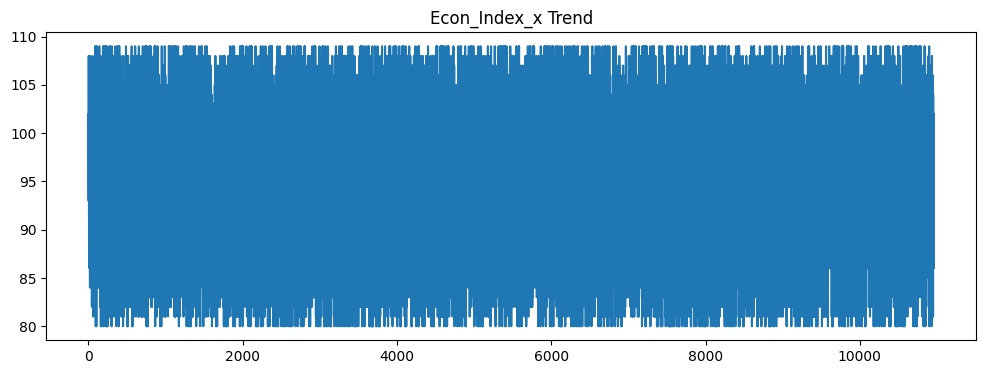

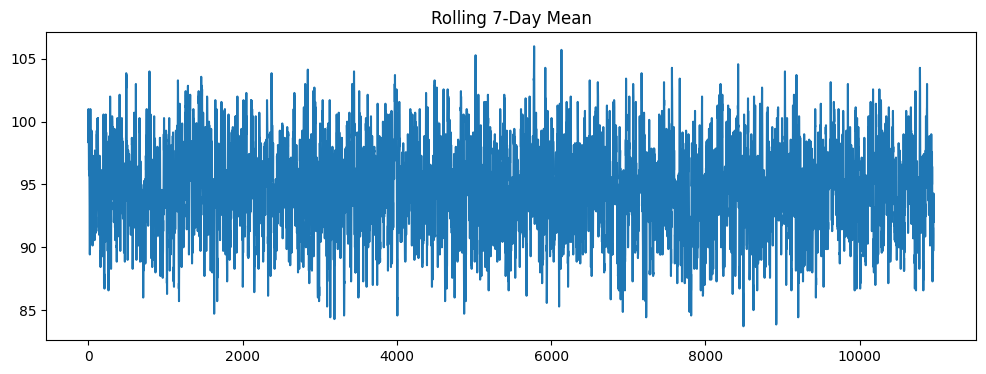

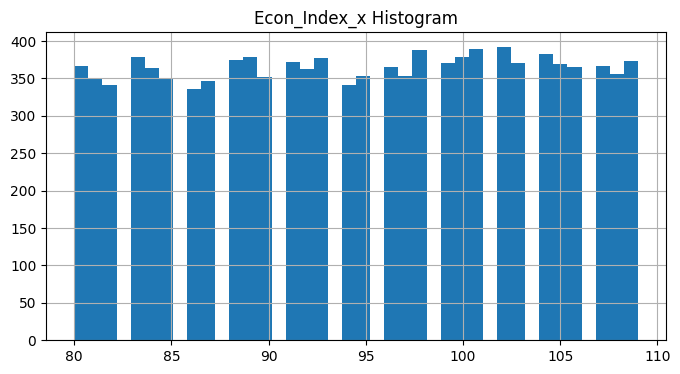

Gold Layer Completed.


In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

SILVER_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/silver_merged/"
GOLD_PATH   = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/"

date_col = None
for c in gold.columns:
    if "date" in c.lower():
        date_col = c
        gold[c] = pd.to_datetime(gold[c], format="%d/%m/%Y", errors="coerce")
        break

print("Gold Layer → date_col =", date_col)

target_candidates = [c for c in gold.columns if any(x in c.lower() for x in ["demand", "sales", "qty", "quantity", "index", "target"])]
target_col = target_candidates[0] if target_candidates else None
print("Gold Layer → target_col =", target_col)

for c in gold.select_dtypes(include=[np.number]).columns:
    gold[c] = gold[c].fillna(gold[c].median())

for c in gold.select_dtypes(include=["object","category"]).columns:
    gold[c] = gold[c].fillna("UNKNOWN")

if date_col:
    gold = gold.sort_values(date_col)
    gold["year"] = gold[date_col].dt.year
    gold["month"] = gold[date_col].dt.month
    gold["day"] = gold[date_col].dt.day
    gold["weekday"] = gold[date_col].dt.weekday

if target_col:
    gold["lag_1"] = gold[target_col].shift(1).fillna(method="bfill")
    gold["rolling_7"] = gold[target_col].rolling(7, min_periods=1).mean()
    gold["rolling_14"] = gold[target_col].rolling(14, min_periods=1).mean()

gold_spark = spark.createDataFrame(gold)

gold_spark.write.mode("overwrite").option("header", True).csv(GOLD_PATH + "gold_features")

print("Gold CSV written to:", GOLD_PATH + "gold_features")

plt.figure(figsize=(12,4))
if target_col:
    gold[target_col].plot(title=f"{target_col} Trend")
    plt.show()

if "rolling_7" in gold.columns:
    plt.figure(figsize=(12,4))
    gold["rolling_7"].plot(title="Rolling 7-Day Mean")
    plt.show()

if target_col:
    plt.figure(figsize=(8,4))
    gold[target_col].hist(bins=40)
    plt.title(f"{target_col} Histogram")
    plt.show()

print("Gold Layer Completed.")